In [28]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
#from tqdm import tqdm
import sys
sys.path.append("/home/yufan") 
#from perturbgene.data_utils import GeneTokenizer, read_h5ad_file
import scanpy as sc
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import pandas as pd
import glob
import re

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.insert(0, parent_dir)

from age_map import age_label_mapping_10, age_label_mapping_20
from analysis_utils import sim_gene_age, sim_celltype_age, sim_gene_youngest, sim_tissue_age, sim_gene_each_group, sim_gene_gene

In [2]:
adata = sc.read_h5ad("chunk3562_stress_tumor_repair2.h5ad")
adata.obs["age_group_10"] = adata.obs["development_stage"].map(age_label_mapping_10)
adata.obs["age_group_20"] = adata.obs["development_stage"].map(age_label_mapping_20)
adata

/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 10000 × 58604
    obs: 'soma_joinid_column', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', 'GDF15_embedding_status', 'NPY_embedding_status', 'TFPI2_embedding_status', 'MEG3_embedding_status', 'WIF1_embedding_status', 'HACE1_embedding_status', 'SGK1_embedding_status', 'LRRC3B_embedding_status', 'MKRN1_embedding_status', 'THY1_embedding_status', 'LZTFL1_embedding_status', 'DUSP26_embedding_status', 'TMEFF2_embedding_status', 'PAX1_embedding_status', 'CXXC4_embedding_status', 'MXI1_embedding_s

### Figure 2: Age Prediction vs chronological age label

In [20]:
def plot_z_score(y_test,y_pred, fig_name = "plots/age_prediction_z_score.png"):
    # Calculate Pearson correlation
    r, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation (r): {r:.2f}')

    # Calculate the z-scored age gap - (age gap - mean of age gap)/sd of age gap
    age_gap = y_pred - y_test
    mean_age_gap = np.mean(age_gap)
    std_age_gap = np.std(age_gap)
    z_scored_age_gap = (age_gap - mean_age_gap) / std_age_gap

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, hue=z_scored_age_gap, palette='coolwarm', edgecolor='k', alpha=0.6, legend=False)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    norm = plt.Normalize(z_scored_age_gap.min(), z_scored_age_gap.max())
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='z-scored age gap')
    plt.xlabel('chronological age',fontsize=18)
    plt.ylabel('predicted age',fontsize=18)
    plt.title(f'age prediction',fontsize=18)
    plt.text(0.05, 0.95, f'r = {r:.2f}', transform=plt.gca().transAxes, 
            fontsize=18, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"))
    plt.savefig(fig_name, dpi=300, bbox_inches='tight') 
    plt.show()

Pearson correlation (r): 0.96


/tmp/ipykernel_11513/634496731.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z-scored age gap')


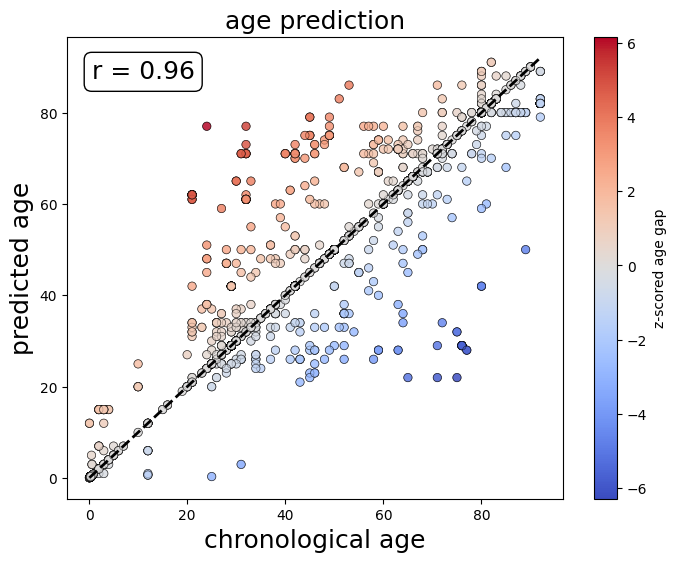

In [21]:
adata_cut = adata[adata.obs["disease"] == "normal"]
ground_truth = adata_cut.obs["development_stage"].apply(label_to_float).to_list()
prediction = adata_cut.obs["prediction_age"].apply(label_to_float).to_list()
y_test, y_pred = zip(*[(x, y) for x, y in zip(ground_truth, prediction) if x != -1.0 and y != -1.0])
y_test = np.array(list(y_test))
y_pred = np.array(list(y_pred))

plot_z_score(y_test, y_pred)

Pearson correlation (r): 0.98


/tmp/ipykernel_11513/634496731.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z-scored age gap')


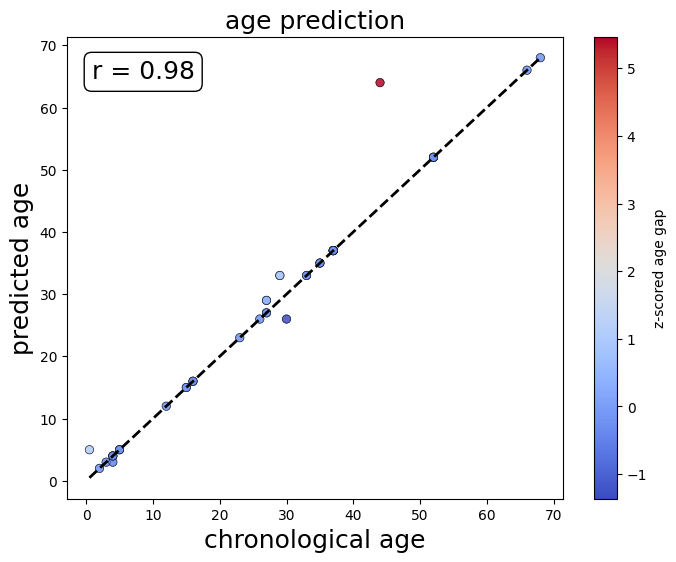

In [23]:
tissue = "respiratory airway"
adata_cut = adata[(adata.obs["disease"] == "normal") & (adata.obs["tissue"] == tissue)]
ground_truth = adata_cut.obs["development_stage"].apply(label_to_float).to_list()
prediction = adata_cut.obs["prediction_age"].apply(label_to_float).to_list()
y_test, y_pred = zip(*[(x, y) for x, y in zip(ground_truth, prediction) if x != -1.0 and y != -1.0])
y_test = np.array(list(y_test))
y_pred = np.array(list(y_pred))

plot_z_score(y_test, y_pred, f"plots/{tissue}_age_prediction_z_score.png")

Pearson correlation (r): 0.62


/tmp/ipykernel_11513/634496731.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z-scored age gap')


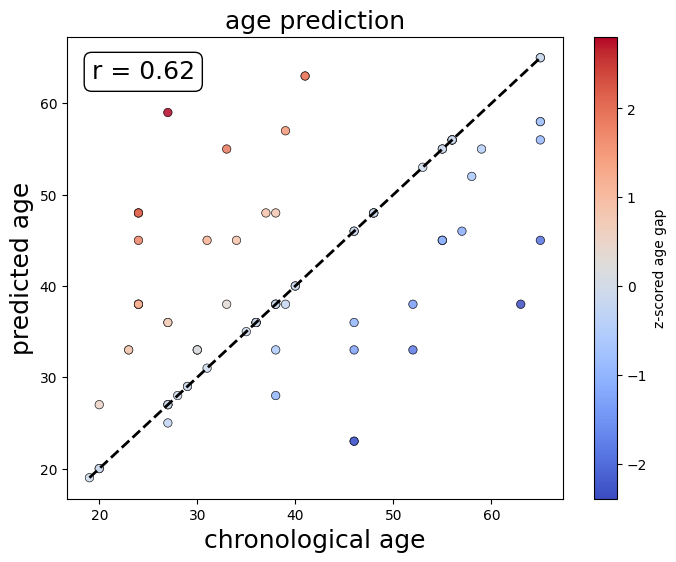

In [24]:
tissue = "breast"
adata_cut = adata[(adata.obs["disease"] == "normal") & (adata.obs["tissue"] == tissue)]
ground_truth = adata_cut.obs["development_stage"].apply(label_to_float).to_list()
prediction = adata_cut.obs["prediction_age"].apply(label_to_float).to_list()
y_test, y_pred = zip(*[(x, y) for x, y in zip(ground_truth, prediction) if x != -1.0 and y != -1.0])
y_test = np.array(list(y_test))
y_pred = np.array(list(y_pred))

plot_z_score(y_test, y_pred, f"plots/{tissue}_age_prediction_z_score.png")

### Fig 3: cell-type-specific age predictions

In [4]:
adata_cut = adata[adata.obs["disease"] == "normal"]
data = pd.DataFrame({
    'Predicted Age': adata_cut.obs["prediction_age"].apply(label_to_float).to_list(),
    'Ground Truth Age': adata_cut.obs["development_stage"].apply(label_to_float).to_list(),
    'Cell Type': adata_cut.obs["cell_type"].to_list()
})

# Filter out invalid values
data = data[(data['Predicted Age'] != -1) & (data['Ground Truth Age'] != -1)]
unique_cell_types = data['Cell Type'].unique()
for cell_type in unique_cell_types:
    subset = data[data['Cell Type'] == cell_type]
    if len(subset) > 10:  # Filter for sufficient data
        plt.figure(figsize=(12, 8))
        sns.regplot(x="Ground Truth Age", y="Predicted Age", data=subset, ci=None, scatter_kws={"s": 20, "color": "blue"}, line_kws={"color": "black"})
        
        # Calculate correlation
        correlation = subset.corr().loc["Ground Truth Age", "Predicted Age"]
        if pd.notna(correlation):
            plt.text(0.1, 0.9, f'R = {correlation:.2f}', transform=plt.gca().transAxes, fontsize=18, verticalalignment='top')
        
        # Set labels and titles
        plt.xlabel("Chronological age",fontsize=18)
        plt.ylabel("Predicted chronological age",fontsize=18)
        plt.title(f'Age Prediction vs Ground Truth for Cell Type: {cell_type}',fontsize=18)
        output_dir = "cell_type"
        # Save plot
        plt.savefig(os.path.join(output_dir, f'{cell_type.replace(" ","_").replace("/","_")}_plot.png'), bbox_inches='tight')
        plt.close()

/tmp/ipykernel_61792/2189127356.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = subset.corr().loc["Ground Truth Age", "Predicted Age"]


/tmp/ipykernel_61792/3763033040.py:31: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = subset.corr().loc["Ground Truth Age", "Predicted Age"]


<Figure size 1200x800 with 0 Axes>

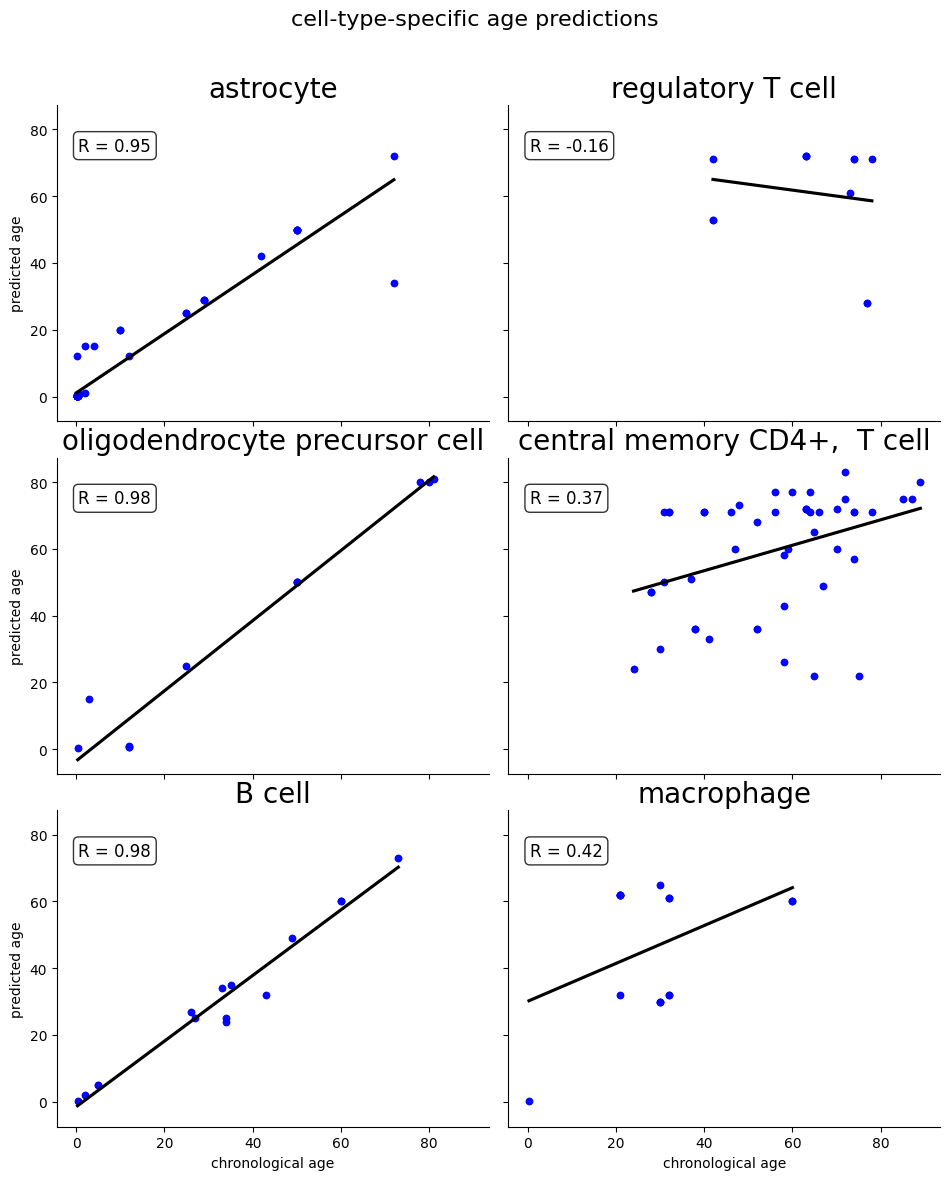

In [5]:
adata_cut = adata[adata.obs["disease"] == "normal"]
data = pd.DataFrame({
    'Predicted Age': adata_cut.obs["prediction_age"].apply(label_to_float).to_list(),
    'Ground Truth Age': adata_cut.obs["development_stage"].apply(label_to_float).to_list(),
    'Cell Type': adata_cut.obs["cell_type"].to_list()
})
data = data[(data['Predicted Age'] != -1) & (data['Ground Truth Age'] != -1)]
valid_cell_types = ['astrocyte','regulatory T cell','oligodendrocyte precursor cell',
                    'central memory CD4-positive, alpha-beta T cell',
                    'B cell','macrophage']
filtered_data = data[data['Cell Type'].isin(valid_cell_types)]


# plot
plt.figure(figsize=(12, 8))
g = sns.FacetGrid(filtered_data, col="Cell Type", col_wrap=2, height=4, aspect=1.2, col_order=valid_cell_types)
g.map(
    sns.regplot, 
    "Ground Truth Age", 
    "Predicted Age", 
    ci=None, 
    scatter_kws={"s": 20, "color": "blue"}, 
    line_kws={"color": "black"}
)
for ax in g.axes.flat:
    title = ax.get_title()
    cell_type = title.split(" = ")[-1] 
    formatted_title = cell_type.replace("-positive", "+").replace("alpha-beta",'') # rename to make it shorter for this cell type
    ax.set_title(formatted_title, fontsize=20)
    subset = filtered_data[filtered_data["Cell Type"] == cell_type]
    correlation = subset.corr().loc["Ground Truth Age", "Predicted Age"]
    if pd.notna(correlation):
        ax.text(
            0.05, 0.9, 
            f'R = {correlation:.2f}', 
            transform=ax.transAxes, 
            fontsize=12, 
            verticalalignment='top', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", alpha=0.8), 
            color="black"
        )
g.set_axis_labels("chronological age", "predicted age")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("cell-type-specific age predictions", fontsize=16)
plt.savefig("plots/cell-type-specific age predictions.png", dpi=300, bbox_inches='tight')
plt.show()

### Figure 4: Similarity between cell type token and age token

In [16]:
cosine_similarity_dict = {}
adata_cut = adata[adata.obs["disease"] == "normal"]
embedding_1 = adata_cut.obsm["cell_type_embeddings"]
embedding_2 = adata_cut.obsm["development_stage_embeddings"]
cell_types = adata_cut.obs["cell_type"]

# calculate cosine similiarity group by cell types
for cell_type in cell_types.unique():
    cell_indices = adata_cut.obs["cell_type"] == cell_type
    subset_embedding_1 = embedding_1[cell_indices]
    subset_embedding_2 = embedding_2[cell_indices]
    similarity_matrix = cosine_similarity(subset_embedding_1, subset_embedding_2)
    cosine_similarity_dict[cell_type] = np.diag(similarity_matrix)

/tmp/ipykernel_174690/3376693162.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cell type', y='cosine similarity', data=df, palette="magma_r")


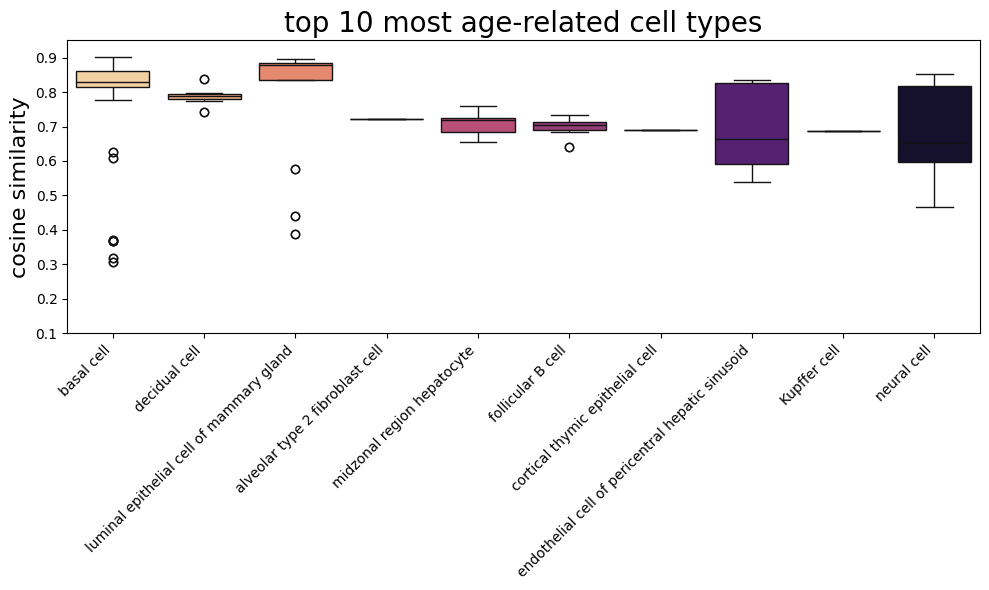

In [22]:
top10 = sorted(cosine_similarity_dict.items(), key=lambda x: np.mean(x[1]), reverse=True)[:10]
plot_data = {
    'cell type': [],
    'cosine similarity': []
}
for cell_type, cosine_similarity_values in top10:
    plot_data['cell type'].extend([cell_type] * len(cosine_similarity_values))
    plot_data['cosine similarity'].extend(cosine_similarity_values)
df = pd.DataFrame(plot_data)
#df.to_csv("mean_top10age-celltype.csv")

plt.figure(figsize=(10, 6))
sns.boxplot(x='cell type', y='cosine similarity', data=df, palette="magma_r")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.1, 0.95)
plt.title('top 10 most age-related cell types',fontsize=20)
plt.xlabel('', fontsize=16)
plt.ylabel('cosine similarity', fontsize=16)
plt.tight_layout()
plt.savefig("plots/mean_top10_most age-related cell types.png", dpi=300, bbox_inches='tight')

/tmp/ipykernel_174690/847789566.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cell type', y='cosine similarity', data=df, palette="magma")


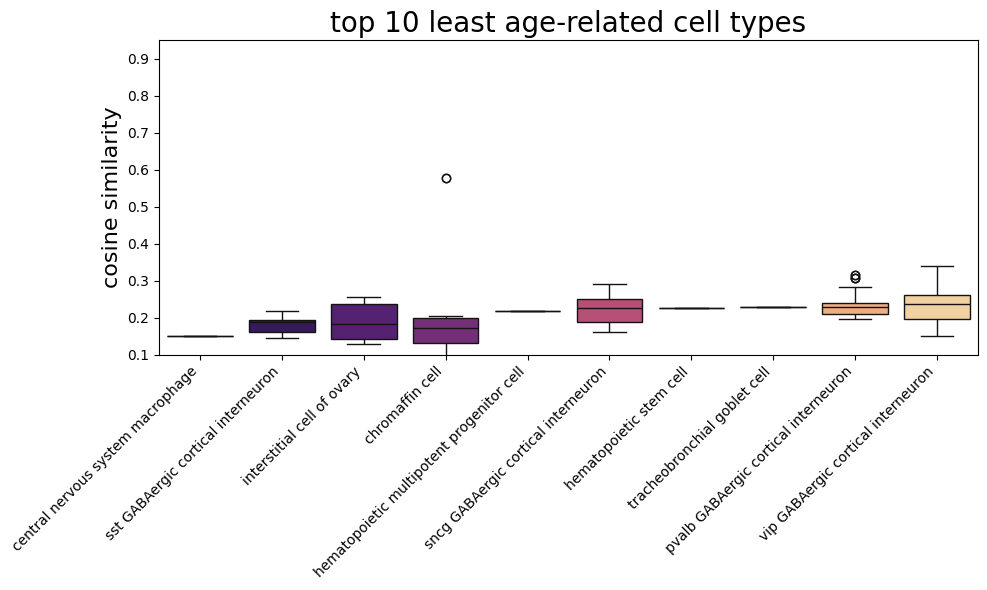

In [23]:
top10 = sorted(cosine_similarity_dict.items(), key=lambda x: np.mean(x[1]))[:10]
plot_data = {
    'cell type': [],
    'cosine similarity': []
}
for cell_type, cosine_similarity_values in top10:
    plot_data['cell type'].extend([cell_type] * len(cosine_similarity_values))
    plot_data['cosine similarity'].extend(cosine_similarity_values)
df = pd.DataFrame(plot_data)
#df.to_csv("mean_last10age-celltype.csv")

plt.figure(figsize=(10, 6))
sns.boxplot(x='cell type', y='cosine similarity', data=df, palette="magma")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.1, 0.95)
plt.xlabel('', fontsize=16)
plt.ylabel('cosine similarity', fontsize=16)
plt.title('top 10 least age-related cell types',fontsize=20)
plt.tight_layout()
plt.savefig("plots/mean_top10_least age-related cell types.png", dpi=300, bbox_inches='tight')

### Fig 5: Dynamics of changes in aging using z-scored age gap

In [6]:
ground_truth = [label_to_float(label) for label in adata.obs["development_stage"]]
predictions = [label_to_float(label) for label in adata.obs["prediction_age"]]

df = pd.DataFrame({
    'Ground Truth': ground_truth,
    'Prediction': predictions
})

df = df[df['Prediction'] != -1]
df['Age Gap'] = df['Prediction'] - df['Ground Truth']
df = df[df['Age Gap'] != 0]
mean_gap = df['Age Gap'].mean()
std_gap = df['Age Gap'].std()
df['Z-Score'] = (df['Age Gap'] - mean_gap) / std_gap

/tmp/ipykernel_174690/1395907410.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Age Gap Range', y='Z-Score', data=df, scale='width', inner='quartile',palette="viridis_r")
/tmp/ipykernel_174690/1395907410.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Age Gap Range', y='Z-Score', data=df, scale='width', inner='quartile',palette="viridis_r")


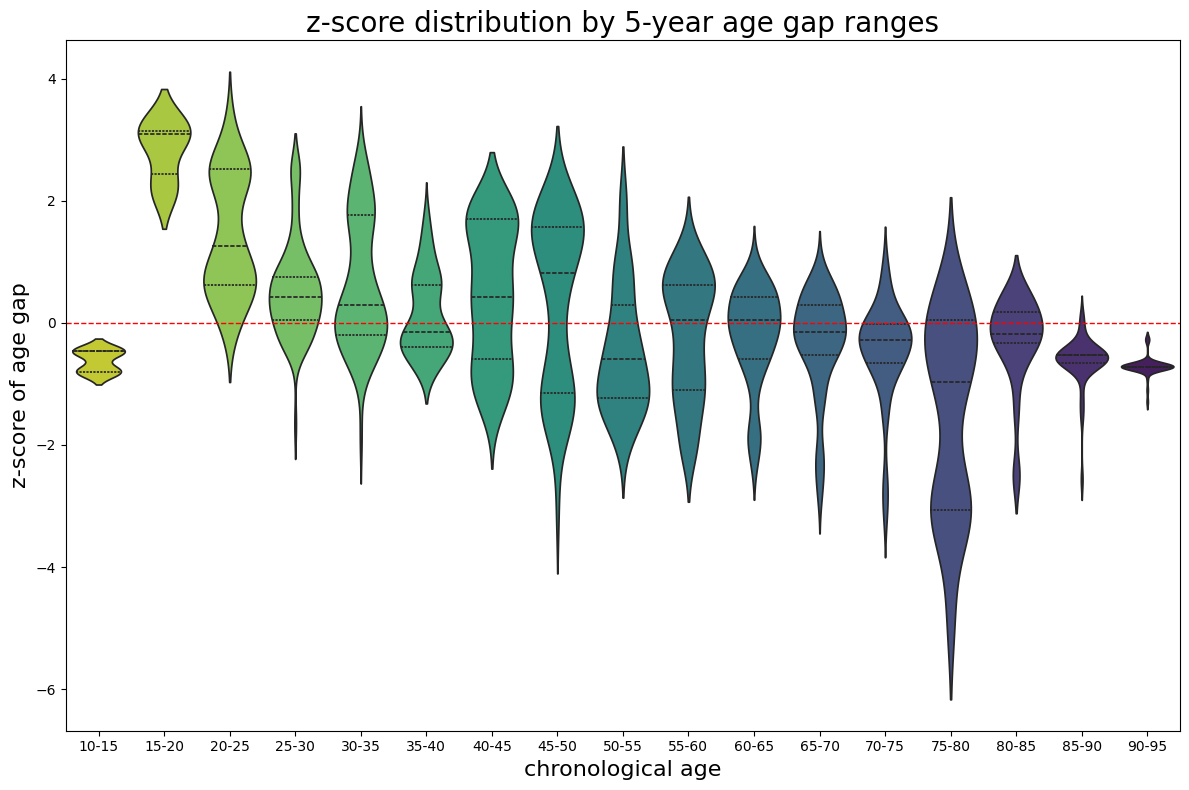

In [15]:
bins = range(10, 100, 5)  # 0-5, 5-10, ..., 95-100
labels = [f"{i}-{i+5}" for i in bins[:-1]]
df = df[df["Ground Truth"] > 10]
df['Age Gap Range'] = pd.cut(df['Ground Truth'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(12, 8))
sns.violinplot(x='Age Gap Range', y='Z-Score', data=df, scale='width', inner='quartile',palette="viridis_r")
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('z-score distribution by 5-year age gap ranges',fontsize=20)
plt.xlabel('chronological age',fontsize=16)
plt.ylabel('z-score of age gap',fontsize=16)
plt.tight_layout()
plt.savefig("plots/z_score_5year_gap.png", dpi=300, bbox_inches='tight')

### Fig 6: Tissue-dependent and cell-type-specific aging dynamics

In [ ]:
def top3genes_by_age(tissue, age_mapping=age_label_mapping_10, threshold=0.01, top_n=3):
    #count number of samples for each age stage
    age_count = {}

    files = glob.glob(f"general_tissue_{tissue}_genes_by_age/{tissue}_chunk*_by_age.pkl")

    chunk_numbers = []
    pattern = re.compile(rf"{tissue}_chunk(\d+)(?:_cells_\d+_\d+)?_by_age\.pkl")

    for file in files:
        match = pattern.search(file)
        if match:
            # Append the chunk number to the list
            chunk_numbers.append(int(match.group(1)))
    
    for chunk in chunk_numbers:
        validation_data = sc.read_h5ad(f"/storage_bizon/sabrant_rocket_2tb/farhan/cellxgene/primary/cxg_chunk{chunk}.h5ad")
        validation_data.obs["age_group"] = validation_data.obs["development_stage"].map(age_mapping)
        filtered_data = validation_data[((validation_data.obs['cell_type'] == tissue)|
                                         (validation_data.obs['tissue_general'] == tissue)
                                         ) & (validation_data.obs["disease"] == "normal")]
        chunk_age_counts = filtered_data.obs["age_group"].value_counts()
        for age_group, count in chunk_age_counts.items():
            if age_group in age_count:
                age_count[age_group] += count
            else:
                age_count[age_group] = count

    #load data
    folder_path = f"general_tissue_{tissue}_genes_by_age"
    files = glob.glob(f"{folder_path}/{tissue}_chunk*_by_age.pkl")

    # Dictionary to store combined cosine similarities
    gene_cos_sim_by_age = {}
    print(files)
    # Load each file and update the main dictionary
    for file in files:
        try:
            with open(file, "rb") as f:
                print(file, "loaded")
                chunk_data = pickle.load(f)
                gene_cos_sim_by_age.update(chunk_data)
        except EOFError:
            print(f"Warning: Could not load {file} (file may be empty or corrupted)")
            """
    for i in range(3562, 3575):
        path2sim = f"{tissue}_genes_by_age/{tissue}_chunk{i}_by_age.pkl" 
        with open(path2sim, "rb") as f:
            chunk_data = pickle.load(f)
            print(path2sim, "loaded")
            gene_cos_sim_by_age.update(chunk_data)
"""

    #compute top 3 genes for each age stage, genes must express in > 1% of all samples
    data = []
    for gene, age_groups in gene_cos_sim_by_age.items():
        for age_group, values in age_groups.items():
            mapped_age_group = age_mapping.get(age_group, age_group)
            if mapped_age_group in age_count:
                if len(values) >= threshold * age_count[mapped_age_group]:
                    mean_cos_sim = sum(values) / len(values)
                    data.append([gene, mapped_age_group, mean_cos_sim])
    df = pd.DataFrame(data, columns=['Gene', 'Age Group', 'Mean Cosine Similarity'])
    top_genes_by_age_group = df.groupby('Age Group').apply(lambda x: x.nlargest(top_n, 'Mean Cosine Similarity')).reset_index(drop=True)
    return (
        top_genes_by_age_group[top_genes_by_age_group["Age Group"] != 'unknown']
        .groupby("Age Group")["Gene"]
        .apply(list)
        .to_dict()
    )

In [30]:
def top3genes_by_age(tissue, age_mapping=age_label_mapping_10, threshold=0.01, top_n=3):
    # Count the number of samples for each age stage
    age_count = {}
    files = glob.glob(f"general_tissue_{tissue}_genes_by_age/{tissue}_chunk*_by_age.pkl")
    chunk_numbers = []
    pattern = re.compile(rf"{tissue}_chunk(\d+)(?:_cells_\d+_\d+)?_by_age\.pkl")

    for file in files:
        match = pattern.search(file)
        if match:
            chunk_numbers.append(int(match.group(1)))

    chunk_numbers.sort()  # Ensure chunks are processed in order
    chunk_numbers = set(chunk_numbers)
    #print(f'for {tissue}: {chunk_numbers}')

    # Count the number of cells per age group
    for chunk in chunk_numbers:
        validation_data = sc.read_h5ad(f"/storage_bizon/sabrant_rocket_2tb/farhan/cellxgene/primary/cxg_chunk{chunk}.h5ad")
        validation_data.obs["age_group"] = validation_data.obs["development_stage"].map(age_mapping)
        filtered_data = validation_data[((validation_data.obs['cell_type'] == tissue) |
                                         (validation_data.obs['tissue_general'] == tissue))
                                         & (validation_data.obs["disease"] == "normal")]
        chunk_age_counts = filtered_data.obs["age_group"].value_counts()
        for age_group, count in chunk_age_counts.items():
            age_count[age_group] = age_count.get(age_group, 0) + count
    
    # Load cosine similarity data
    gene_cos_sim_by_age = {}
    for file in files:
        try:
            with open(file, "rb") as f:
                chunk_data = pickle.load(f)
                gene_cos_sim_by_age.update(chunk_data)
        except EOFError:
            print(f"Warning: Could not load {file} (file may be empty or corrupted)")
            continue

    # Compute top 3 genes for each age group
    data = []
    for gene, age_groups in gene_cos_sim_by_age.items():
        for age_group, values in age_groups.items():
            mapped_age_group = age_mapping.get(age_group, age_group)
            if mapped_age_group in age_count and age_count[mapped_age_group] > 0:
                if len(values) >= threshold * age_count[mapped_age_group]:
                    mean_cos_sim = sum(values) / len(values)
                    data.append([gene, mapped_age_group, mean_cos_sim])
    
    df = pd.DataFrame(data, columns=['Gene', 'Age Group', 'Mean Cosine Similarity'])
    top_genes_by_age_group = df.groupby('Age Group').apply(lambda x: x.nlargest(top_n, 'Mean Cosine Similarity')).reset_index(drop=True)
    
    # Return the top genes as a dictionary
    return (
        top_genes_by_age_group[top_genes_by_age_group["Age Group"] != 'unknown']
        .groupby("Age Group")["Gene"]
        .apply(list)
        .to_dict(), chunk_numbers
    )


In [15]:
tissue_top3genes = {}
threshold = 0.01
for tissue in ['liver', 'heart','lung', 'kidney',  'bone marrow', 'breast','blood',"brain"]:
    tissue_top3genes[tissue] = top3genes_by_age(tissue, threshold=threshold)
tissue_top3genes

/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Tran

{'liver': {'20-30': ['PIK3R5', 'FUT8', 'RP11-846F4.11'],
  '60-70': ['RPS12', 'CH17-258A22.4', 'KCNC3'],
  '>80': ['RNA5SP352', 'RP11-565O12.1', 'SAMD13']},
 'heart': {'30-40': ['RP11-403E24.1', 'U8_ENSG00000201810', 'MIR4263'],
  '40-50': ['KIR3DP1', 'MIR4667', 'RAP1A'],
  '50-60': ['CH507-39O4.2', 'MIR4303', 'AF254982.2'],
  '60-70': ['MIR6861', 'FZD2', 'KRT16P1'],
  '70-80': ['RP11-394I13.2', 'RP11-756J15.3', 'LINC02599'],
  '>80': ['AC004381.7', 'SPTB', 'RP11-536C12.1']},
 'lung': {'10-20': ['VN1R105P', 'RNU6-1039P', 'MICF'],
  '20-30': ['RPSAP4', 'RPS12', 'RPS12'],
  '30-40': ['RNU7-75P', 'RP11-404G16.2', 'ACTG1P11'],
  '40-50': ['RP11-394I13.2', 'RP11-756J15.3', 'RPSAP4'],
  '50-60': ['KCNC3', 'PSMC1P12', 'RPSAP4'],
  '60-70': ['RPSAP4', 'RP11-409O11.3', 'SLC9A3-AS1'],
  '70-80': ['TACSTD2', 'PDE6G', 'RP11-613E4.5'],
  '>80': ['TNPO1P3', 'SPANXB1', 'RNU6-637P']},
 'kidney': {'10-20': ['SLC43A2', 'Y_RNA_ENSG00000206582', 'RP11-613E4.5'],
  '40-50': ['RP11-5P4.3', 'RP11-701P16.6', 

In [33]:
df.to_csv("tissue_top3genes.csv", index=False)


In [31]:
tissue_top3genes = {}
chunk_numbers = []
threshold = 0.001
for tissue in ['liver', 'heart','lung', 'kidney',  'bone marrow', 'breast','blood',"brain", 'macrophage', 'regulatory T cell']:
    tissue_top3genes[tissue], chunk_number = top3genes_by_age(tissue, threshold=threshold)
    chunk_numbers.append(chunk_number)
rows = []
for (tissue, values), chunk_number in zip(tissue_top3genes.items(), chunk_numbers):
    for ages, genes in values.items():
        rows.append({"Tissue/Cell_type": tissue, "Age":ages, "Gene": genes, "Chunk_Number": chunk_number})
df = pd.DataFrame(rows)
#df.to_csv("tissue_top3genes.csv", index=False)
df

/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Tran

,Tissue/Cell_type,Age,Gene,Chunk_Number
0,liver,20-30,"[PIK3R5, FUT8, RP11-846F4.11]","{3562, 3563, 3564, 3565, 3566, 3567, 3568, 356..."
1,liver,60-70,"[RPS6KA6, Y_RNA_ENSG00000200432, RP11-566H8.1]","{3562, 3563, 3564, 3565, 3566, 3567, 3568, 356..."
2,liver,>80,"[RNA5SP352, RP11-565O12.1, SAMD13]","{3562, 3563, 3564, 3565, 3566, 3567, 3568, 356..."
3,heart,30-40,"[ZNF768, MIR4533, FGF7P8]","{1083, 1084, 1085, 1086, 1087, 1088, 1089, 109..."
4,heart,40-50,"[RP11-294J22.7, CPSF1P2, Y_RNA_ENSG00000201884]","{1083, 1084, 1085, 1086, 1087, 1088, 1089, 109..."
5,heart,50-60,"[Y_RNA_ENSG00000201547, ENSG00000238326.1, ENS...","{1083, 1084, 1085, 1086, 1087, 1088, 1089, 109..."
6,heart,60-70,"[WARS2, PRMT8, RP11-244G12.1]","{1083, 1084, 1085, 1086, 1087, 1088, 1089, 109..."
7,heart,70-80,"[RP11-426C22.6, RPS6KA1, KLF11]","{1083, 1084, 1085, 1086, 1087, 1088, 1089, 109..."
8,heart,>80,"[AC004381.7, SPTB, RP11-536C12.1]","{1083, 1084, 1085, 1086, 1087, 1088, 1089, 109..."
9,lung,10-20,"[VN1R105P, RNU6-1039P, MICF]","{1000, 3562, 3563, 3564, 3565, 3566, 3567, 356..."


In [20]:
def plot_clock_tissue(tissue,tissue_gene_dict=tissue_top3genes, save_svg=False):
    sizes = [1] * 8  # Equal size for each hour
    labels = ["20y","30y","40y","50y","60y","70y","80y","10y"]
    annotations = [f'Description for {i + 1}' for i in range(8)]  # Example annotations
    age_groups = ["10-20","20-30","30-40","40-50","50-60","60-70","70-80",">80"]
    gene_list = []
    for age_group in age_groups:
        if age_group in tissue_gene_dict[tissue]:
            genes = tissue_gene_dict[tissue][age_group]
            gene_list.append('\n'.join(genes))  # Join the genes for the current age group
        else:
            gene_list.append("")

    fig, ax = plt.subplots(figsize=(8, 8))
    fig.patch.set_alpha(0) 
    wedges, texts = ax.pie(sizes,  labels = gene_list,startangle=90, counterclock=False, colors=sns.color_palette('Set2'))
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(centre_circle)
    ax.axis('equal')
    theta = np.linspace(0, 2 * np.pi, len(sizes) + 1)[1:]  # Angles for each hour
    for i in range(len(sizes)):
        angle = -(theta[i] - np.pi/2)
        x_label = 0.6 * np.cos(angle)  # X-coordinate for label
        y_label = 0.6 * np.sin(angle)  # Y-coordinate for label
        ax.text(x_label, y_label, labels[i], ha='center', va='center', fontsize=12,)
    ax.text(0, 0, tissue, ha='center', va='center', fontsize=16, fontweight='bold')
    if save_svg:
        plt.savefig(f'clock/{tissue}_clock', format='svg')
        plt.close()
    else:
        plt.savefig(f'clock/{tissue}_clock.png', dpi=300, bbox_inches='tight')
        plt.show()

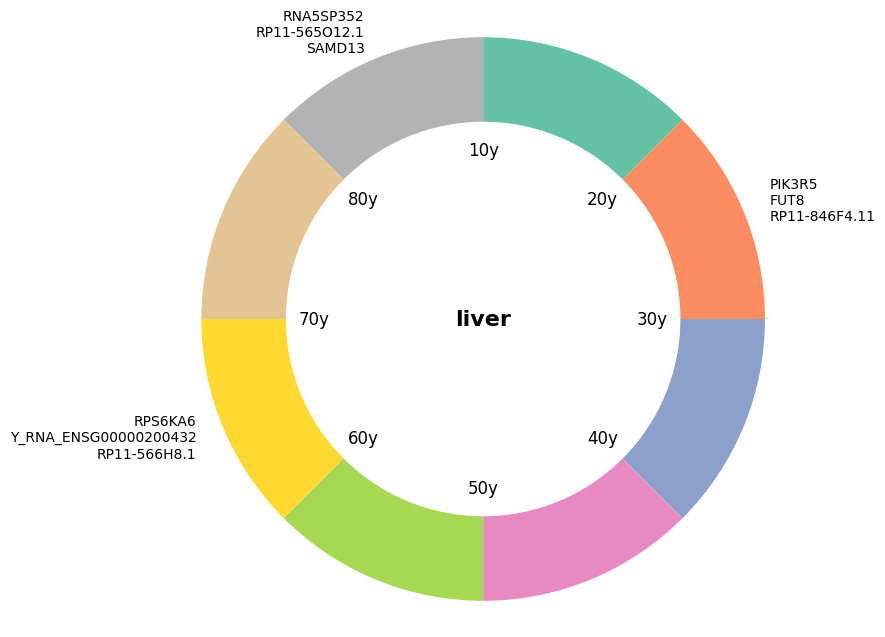

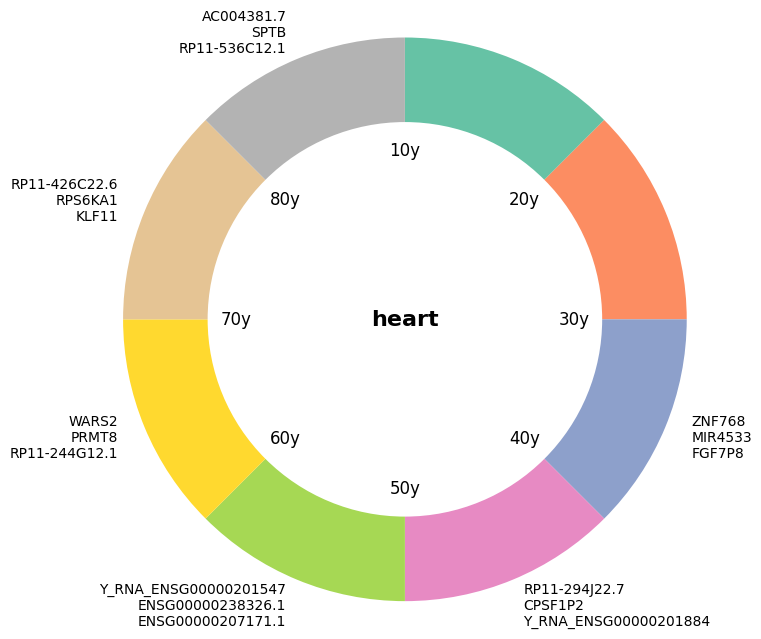

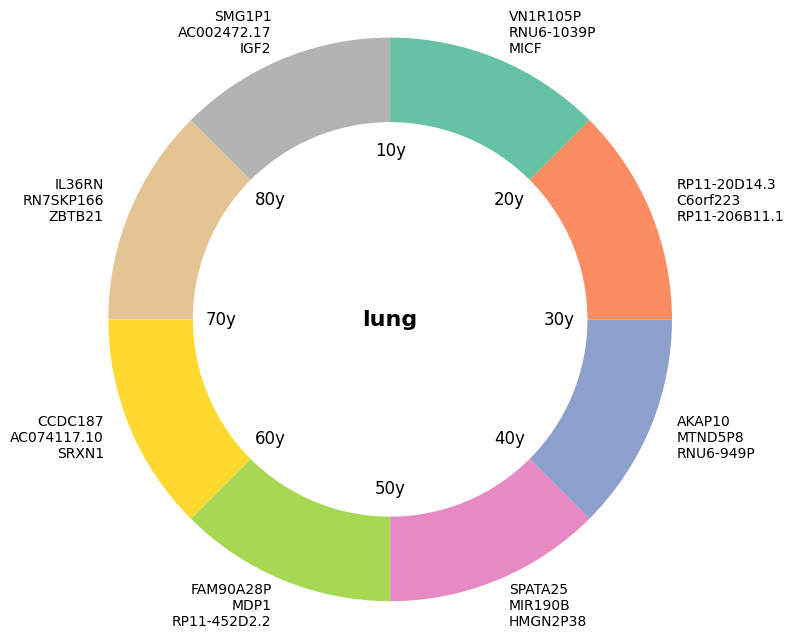

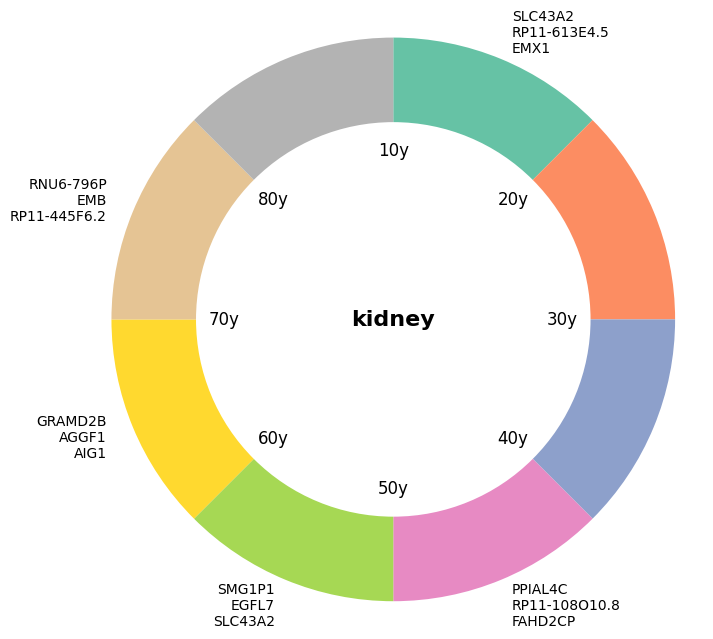

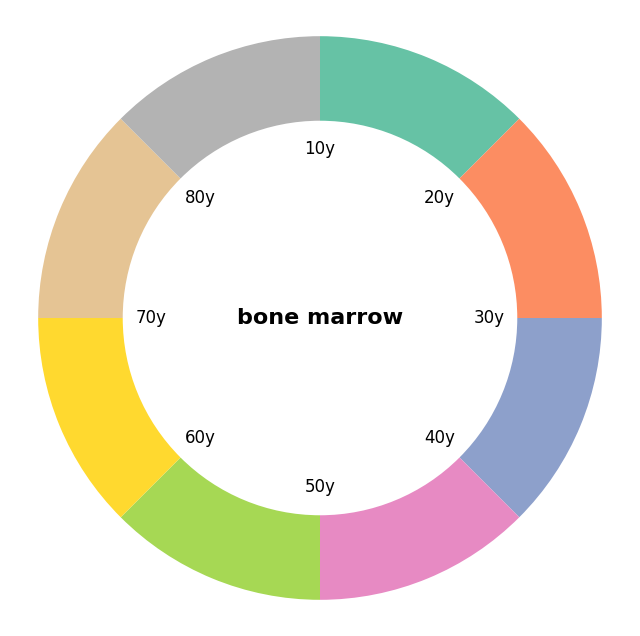

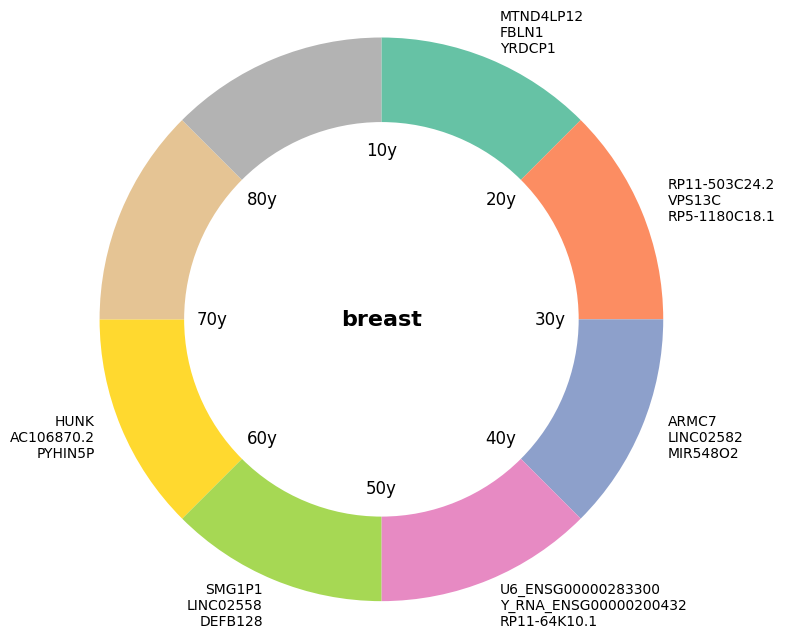

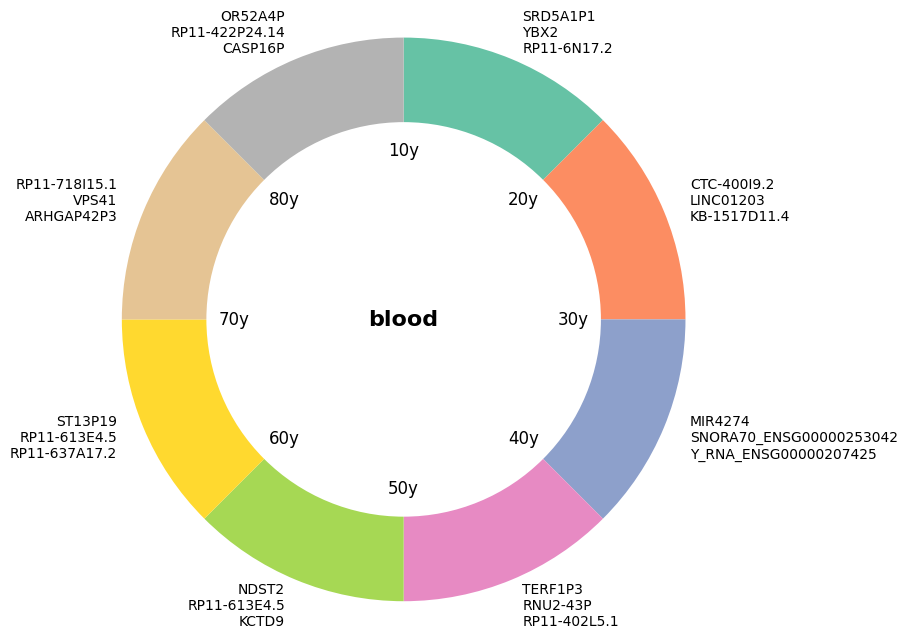

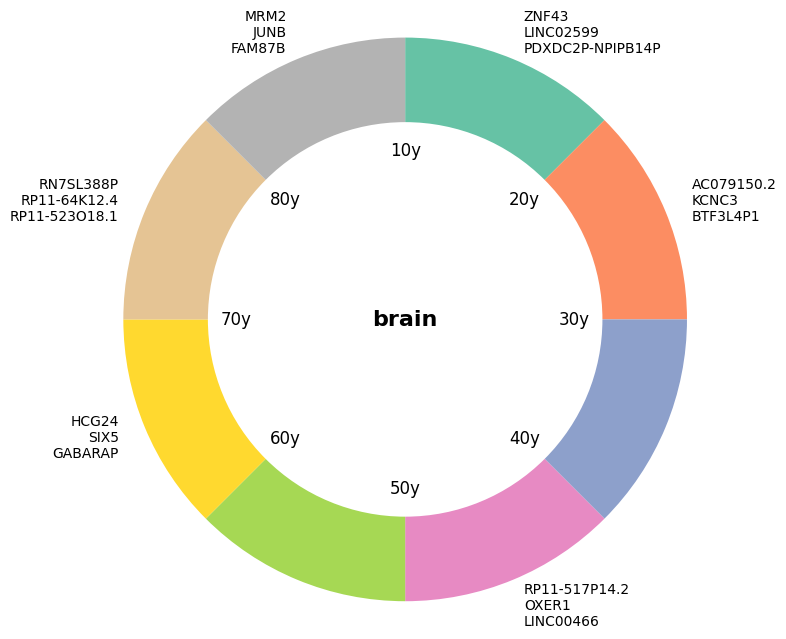

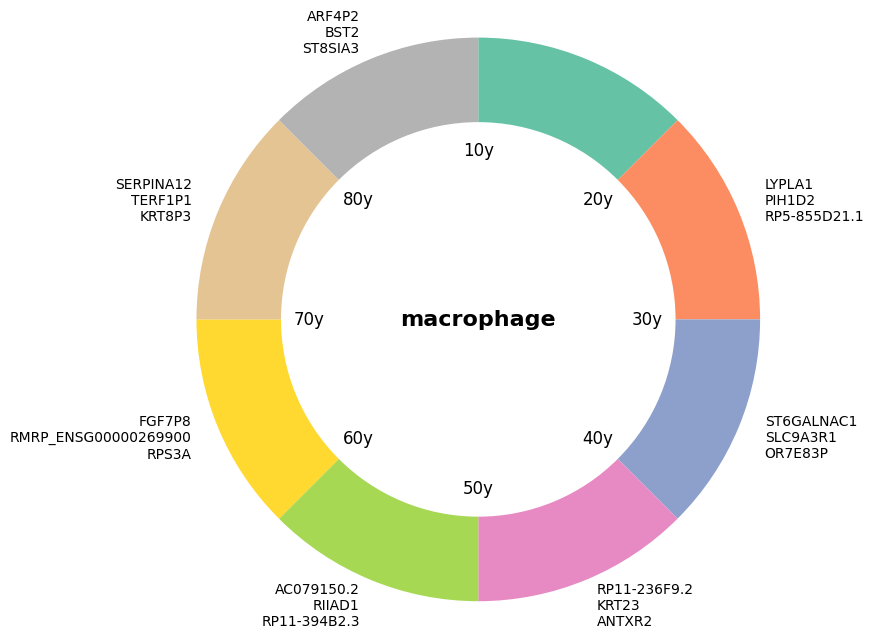

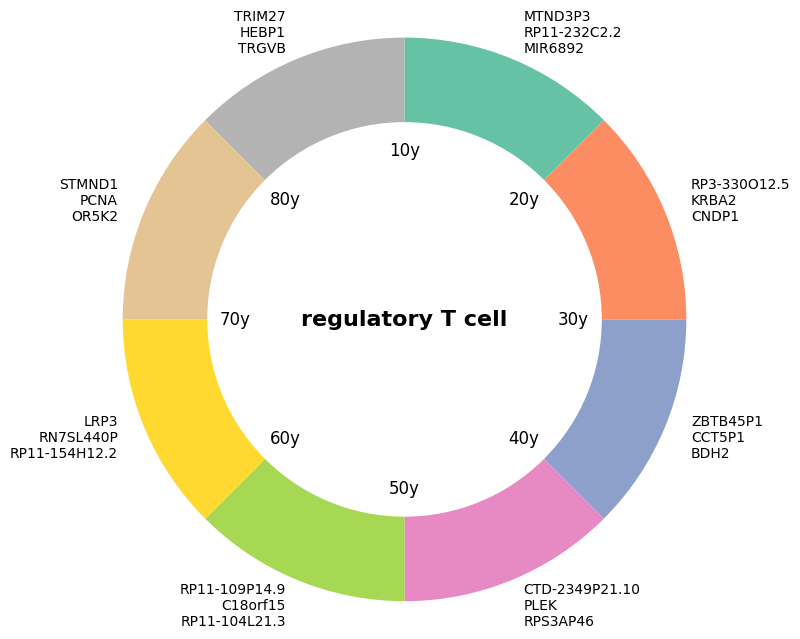

In [32]:
for tissue in ['liver', 'heart','lung', 'kidney',  'bone marrow', 'breast','blood',"brain", 'macrophage', 'regulatory T cell']: # 0.001
    plot_clock_tissue(tissue,tissue_top3genes)

### Fig 7: Temporal drift in gene embedding space during aging: gene variance to youngest group

In [3]:
gene_functions = {
    "ATR": "DNA Repair", #same
    "TDP2": "DNA Repair", #up
    "SAFB2": "Stress Response", #up
    "HERPUD1": "Stress Response", #down
    "MCTP1": "Oxidative Stress", #up
    "HEBP2": "Oxidative Stress", #down
    "SESN1": "Oxidative Stress", #same
    "APC": "Tumor Suppressor", #up
    "MKRN1": "Tumor Suppressor",  #same
    "BANP": "Tumor Suppressor", #down
    "IFITM3":"Immune Response"
}
function_colors = {
    "DNA Repair": "purple",
    "Stress Response": "teal",
    "Oxidative Stress": "orange",
    "Tumor Suppressor": "red",
    "Immune Response":"blue"
}
#age_order = ["<20", "20-40", "40-60", "60-80", ">80"]

In [4]:
gene2youngest_each_group = {}
ref_age = "<20"
age_order = ["<20", "20-40", "40-60", "60-80", ">80"]
do_for_these_genes = gene_functions.keys()
for gene in do_for_these_genes:
    adata_sub = adata[(adata.obs[f'{gene}_embedding_status'] == "present") & (adata.obs["disease"] == "normal")]
    adata_sub = adata_sub[~adata_sub.obs["age_group_20"].isin(["unknown"])]
    gene_embeddings = adata_sub.obsm[f'{gene}_embeddings'] 
    age_groups = adata_sub.obs['age_group_20'].to_list()
    gene2youngest_each_group[gene] = sim_gene_youngest(gene_embeddings, age_group_list=age_groups, ref_age = ref_age, age_order=age_order)

In [19]:
gene2youngest_each_group_p = {}
for gene, values in gene2youngest_each_group.items():
    ref_sims = gene2youngest_each_group[gene][ref_age]
    gene2youngest_each_group_p[gene] = {}
    for age_group, sims in values.items():
        if age_group != ref_age:
            gene2youngest_each_group_p[gene][age_group] = cal_p(values[age_group], ref_sims)
        else:
            gene2youngest_each_group_p[gene][ref_age] = ""

In [ ]:
for gene, age_values in gene2youngest_each_group.items():
    data = []
    mean = np.mean(age_values[ref_age])
    for age, sims in age_values.items():
        for sim in sims:
            data.append({"age group": age, "cosine similarity": sim-mean})
    df = pd.DataFrame(data)
    df['age group'] = pd.Categorical(df['age group'], categories=age_order, ordered=True)

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df, x="age group", y="cosine similarity", marker='o')
    plt.title(f"cosine similarity compare to <20 for {gene}", fontsize=20)
    plt.xlabel('age group', fontsize=16)
    plt.ylabel('adjusted cosine similarity', fontsize=16)
    plt.ylim(-0.5,0.1)
    ylim = plt.gca().get_ylim()
    
    for age, p_star in gene2youngest_each_group_p[gene].items():
        annotation = p_star 
        plt.text(
            age,  
            ylim[1] - 0.05 * (ylim[1] - ylim[0]),  
            annotation,
            ha="center", va="top", fontsize=10, color="black"
        )
    plt.tight_layout()
    plt.savefig(f'paper_plots/compare2youngest/{gene}_withP.png', dpi=300, bbox_inches='tight')
    plt.close()

In [7]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.insert(0, parent_dir)

from age_map import age_label_mapping_10, age_label_mapping_20
from analysis_utils import sim_gene_age, sim
%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'sim' from 'analysis_utils' (/home/yufan/perturbgene/analysis_utils.py)

In [33]:
import importlib
import age_map
import analysis_utils

importlib.reload(age_map)
importlib.reload(analysis_utils)


<module 'analysis_utils' from '/home/yufan/perturbgene/analysis_utils.py'>

In [ ]:
from

### Figure 7c: similarity between genes: check check

In [ ]:
gene2gene_each_group = {}
age_order_10 = ["10-20", "20-30", "30-40", "40-50","50-60", "60-70","70-80",">80"]
ref_gene = "IGHA1"
do_for_these_genes = ["IGHG3", #up
                      "ARHGAP11A", #down
                      "BCL2L12" #down
                      ]
adata_ref = adata[(~adata.obs["age_group_10"].isin(["unknown"])) & (adata.obs["disease"] == "normal")]
for gene in do_for_these_genes:
    geneA_adata = adata_ref[adata_ref.obs[f'{ref_gene}_embedding_status'] == "present"]
    geneB_adata= adata_ref[adata_ref.obs[f'{gene}_embedding_status'] == "present"]
    geneA_embeddings = geneA_adata.obsm[f"{ref_gene}_embeddings"]
    geneB_embeddings= geneB_adata.obsm[f'{gene}_embeddings']
    geneA_age_groups = geneA_adata.obs['age_group_10'].to_list()
    geneB_age_groups = geneB_adata.obs['age_group_10'].to_list()
    gene2gene_each_group[gene] = sim_gene_gene(geneA_embeddings, geneB_embeddings, age_group_list=geneA_age_groups, ref_age_group_list=geneB_age_groups, age_order=age_order_10)

In [79]:
gene2gene_each_group_p = {}
for gene, values in gene2gene_each_group.items():
    gene2gene_each_group_p[gene] = {}
    for age in age_order_10:
        if age == "10-20":
            gene2gene_each_group_p[gene]["10-20"] = ''
        else:
            previous=age_order_10[age_order_10.index(age)-1]
            sims_age_now = values[age]
            sims_age_previous = values[previous]
            if (sims_age_now is not None) and (sims_age_previous is not None):
                gene2gene_each_group_p[gene][age] = cal_p(values[age], values[previous])
            else:
                gene2gene_each_group_p[gene][age] = ""

In [82]:
for gene, age_values in gene2gene_each_group.items():
    data = []
    for age, sims in age_values.items():
        if sims is not None:
            for sim in sims:
                data.append({"age group": age, "cosine similarity": sim})
    df = pd.DataFrame(data)
    df['age group'] = pd.Categorical(df['age group'], categories=age_order_10, ordered=True)

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df, x="age group", y="cosine similarity", marker='o')
    plt.title(f"cosine similarity between {ref_gene} and {gene}", fontsize=20)
    plt.xlabel('age group', fontsize=16)
    plt.ylabel('cosine similarity', fontsize=16)
    ylim = plt.gca().get_ylim()
    
    for age, p_star in gene2gene_each_group_p[gene].items():
        annotation = p_star 
        plt.text(
            age,  
            ylim[1] - 0.05 * (ylim[1] - ylim[0]),  
            annotation,
            ha="center", va="top", fontsize=10, color="black"
        )
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'paper_plots/compare_gene2gene/{ref_gene}_{gene}_withP.png', dpi=300, bbox_inches='tight')
    plt.close() #this function still need to be checked

### Figure 8: conservative genes while aging (gene-age, pairweise, by age group)

In [ ]:
gene2age_each_group = {}
age_order = ["<20", "20-40", "40-60", "60-80", ">80"]
do_for_these_genes = gene_functions.keys()
adata_ref = adata[(~adata.obs["age_group_20"].isin(["unknown"])) & (adata.obs["disease"] == "normal")]
for gene in do_for_these_genes:
    adata_gene = adata_ref[adata_ref.obs[f"{gene}_embedding_status"] == "present"]
    gene_embeddings = adata_gene.obsm[f"{gene}_embeddings"]
    age_embeddings= adata_gene.obsm['development_stage_embeddings']
    age_groups = adata_gene.obs['age_group_20'].to_list()
    gene2age_each_group[gene] = sim_gene_age(gene_embeddings, age_embeddings, age_group_list=age_groups, age_order=age_order)

In [111]:
gene2age_each_group_p = {}
for gene, values in gene2age_each_group.items():
    gene2age_each_group_p[gene] = {}
    for age in age_order:
        if age == "<20":
            gene2age_each_group_p[gene]["<20"] = ''
        else:
            previous=age_order[age_order.index(age)-1]
            sims_age_now = values[age]
            sims_age_previous = values[previous]
            if (sims_age_now is not None) and (sims_age_previous is not None):
                gene2age_each_group_p[gene][age] = cal_p(values[age], values[previous])
            else:
                gene2age_each_group_p[gene][age] = ""

In [119]:
for gene, age_values in gene2age_each_group.items():
    data = []
    for age, sims in age_values.items():
        if sims is not None:
            for sim in sims:
                data.append({"age group": age, "cosine similarity": sim})
    df = pd.DataFrame(data)
    df['age group'] = pd.Categorical(df['age group'], categories=age_order, ordered=True)
    mean_values = df.groupby('age group')['cosine similarity'].mean().reset_index()

    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x="age group", y="cosine similarity")
    plt.plot(
        mean_values['age group'], 
        mean_values['cosine similarity'], 
        marker='o', color='red', linestyle='-', label='Mean Cosine Similarity'
    )
    plt.title(f"cosine similarity between {gene} token and age token", fontsize=18)
    plt.xlabel('age group', fontsize=16)
    plt.ylabel('cosine similarity', fontsize=16)
    plt.ylim(0,0.95)
    ylim = plt.gca().get_ylim()
    
    for age, p_star in gene2age_each_group_p[gene].items():
        annotation = p_star 
        plt.text(
            age,  
            ylim[1] - 0.05 * (ylim[1] - ylim[0]),  
            annotation,
            ha="center", va="top", fontsize=16, color="black"
        )
    
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'paper_plots/compare_gene2age/{gene}_withP.png', dpi=300, bbox_inches='tight')
    plt.close() 

### Fig 9: gene-age in healthy vs. diseased

In [120]:
gene2age_each_group_diseased = {}
age_order = ["<20", "20-40", "40-60", "60-80", ">80"]
do_for_these_genes = gene_functions.keys()
adata_ref = adata[(~adata.obs["age_group_20"].isin(["unknown"])) & (adata.obs["disease"] != "normal")]
for gene in do_for_these_genes:
    adata_gene = adata_ref[adata_ref.obs[f"{gene}_embedding_status"] == "present"]
    gene_embeddings = adata_gene.obsm[f"{gene}_embeddings"]
    age_embeddings= adata_gene.obsm['development_stage_embeddings']
    age_groups = adata_gene.obs['age_group_20'].to_list()
    gene2age_each_group_diseased[gene] = sim_gene_age(gene_embeddings, age_embeddings, age_group_list=age_groups, age_order=age_order)

In [127]:
gene2age_each_group_diseased_p = {}
for gene, values in gene2age_each_group_diseased.items():
    gene2age_each_group_diseased_p[gene] = {}
    for age in age_order:
        sims_age_now = values[age]
        sims_age_previous = gene2age_each_group[gene][age]
        if (sims_age_now is not None) and (sims_age_previous is not None):
            gene2age_each_group_diseased_p[gene][age] = cal_p(values[age], values[previous])
        else:
            gene2age_each_group_diseased_p[gene][age] = ""

/home/yufan/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [158]:
for gene, age_values in gene2age_each_group.items():
    data = []
    for age, sims in age_values.items():
        if sims is not None:
            for sim in sims:
                data.append({"age group": age, "cosine similarity": sim})
    df = pd.DataFrame(data)
    df['age group'] = pd.Categorical(df['age group'], categories=age_order, ordered=True)
    df['disease'] = 'healthy'
    mean_values = df.groupby('age group')['cosine similarity'].mean().reset_index()

    diseased_data = []
    for age, sims in gene2age_each_group_diseased[gene].items():
        if sims is not None:
            for sim in sims:
                diseased_data.append({"age group": age, "cosine similarity": sim})
    diseased_df = pd.DataFrame(diseased_data)
    diseased_df['age group'] = pd.Categorical(diseased_df['age group'], categories=age_order, ordered=True)
    diseased_df["disease"] = "diseased"
    diseased_mean_values = diseased_df.groupby('age group')['cosine similarity'].mean().reset_index()
    combined_df = pd.concat([df,diseased_df])

    mean_values['disease'] = 'healthy'
    diseased_mean_values['disease'] = 'diseased'
    combined_mean_values = pd.concat([mean_values, diseased_mean_values])
    combined_mean_values['age group'] = pd.Categorical(
        combined_mean_values['age group'], 
        categories=["<20", "20-40", "40-60", "60-80", ">80"], 
        ordered=True
    )

    plt.figure(figsize=(8, 6))
    boxplot = sns.boxplot(data=combined_df, x="age group", y="cosine similarity", hue="disease", palette='pastel')

    sns.lineplot(
        data=combined_mean_values,
        x="age group",
        y="cosine similarity",
        hue="disease",
        style="disease",
        markers=["o", "s"], 
        palette={"healthy": "#0047AB", "diseased": "lightcoral"},
        linewidth=2
    )
    sns.move_legend(boxplot, "upper left", bbox_to_anchor=(1, 1))

    plt.title(f"cosine similarity between {gene} token and age token \n in healthy vs. diseased", fontsize=18)
    plt.xlabel('age group', fontsize=16)
    plt.ylabel('cosine similarity', fontsize=16)
    plt.ylim(0,0.95)
    ylim = plt.gca().get_ylim()
    
    
    for age, p_star in gene2age_each_group_diseased_p[gene].items():
        annotation = p_star 
        plt.text(
            age,  
            ylim[1] - 0.05 * (ylim[1] - ylim[0]),  
            annotation,
            ha="center", va="top", fontsize=16, color="black"
        )
    
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'paper_plots/compare_gene2age_with_diseased/{gene}_withP.png', dpi=300, bbox_inches='tight')
    plt.close() 